In [17]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

import sys
sys.path.append('../')
from src import datasets, metrics

In [18]:
trainfile = Path('../data/heart_big_train.parq').resolve()
testfile = Path('../data/heart_big_test.parq').resolve()
trainfile, testfile

(PosixPath('/home/azureuser/code/mads-exam-24/data/heart_big_train.parq'),
 PosixPath('/home/azureuser/code/mads-exam-24/data/heart_big_test.parq'))

Get the 1D data into a 2D matrix

In [19]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
traindataset, testdataset
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"

traindataset.to(device)
testdataset.to(device)


Let's see how that works. 
Compare this to the 1D data to see if you understand the transformation.

(torch.Size([1, 16, 12]), tensor(0))

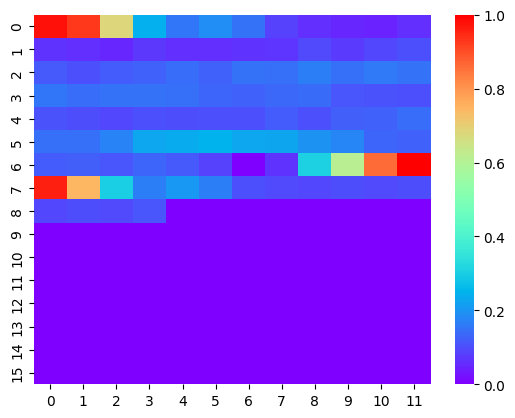

In [20]:
x, y = traindataset[0]
# Assuming your tensor is named 'tensor'
viz = x.squeeze().cpu().numpy()
sns.heatmap(viz, cmap='rainbow')
x.shape, y

Load into a streamer

In [21]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(2736, 684)

In [22]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 1, 16, 12]), torch.Size([32]))

The ConvBlock makes it easier to stack block in the model.
Feel free to experiment with other architectures here:
- adding ideas like resnet, googlenet, squeeze-excite, etc.
- add additional layers like dropout, batchnorm, etc.
- experiment with different ways to go from 4D to 2D tensors

In [26]:
import torch
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.match_dimensions = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            if in_channels != out_channels
            else nn.Identity()
        )
        self.final_norm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x.clone()
        x = self.conv(x)
        identity = self.match_dimensions(identity)
        x += identity
        x = self.final_norm(x)
        return x

In [28]:
class CNN(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config["hidden"]
        dropout = config["dropout"]
        self.convolutions = nn.ModuleList(
            [
                ResBlock(1, hidden, dropout),
            ]
        )

        for i in range(config["num_layers"]):
            self.convolutions.extend([ResBlock(hidden, hidden, dropout), nn.ReLU()])
        self.convolutions.append(nn.MaxPool2d(2, 2))

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((8 * 6) * hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(dropout),  # Add dropout here
            nn.Linear(hidden, config["num_classes"]),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = conv(x)
        x = self.dense(x)
        return x

In [ ]:
import numpy as np
from sklearn.metrics import recall_score

class ThresholdedRecall:
    def __init__(self, threshold: float = 0.2, average: str = 'micro'):
        self.threshold = threshold
        self.average = average

    def __repr__(self) -> str:
        return f"ThresholdedRecall_threshold_{self.threshold}_average_{self.average}"

    def __call__(self, y, yhat):
        yhat_thresholded = (yhat >= self.threshold).astype(int)
        
        if y.ndim == 1:
            # Binary classification case
            y_true = y
            y_pred = yhat_thresholded[:, 0]  # Assuming binary classification has shape (n_samples, 1)
        else:
            # Multilabel case
            y_true = y
            y_pred = yhat_thresholded
        
        return recall_score(
            y_true, y_pred, average=self.average, zero_division=np.nan
        )

In [29]:
#from src import models
config = {
    'hidden' : 111,
    'num_layers' : 3,
    'num_classes' : 5, # 5 for big dataset
    'shape' : shape,
    'dropout': 0.27,
}


model = CNN(config)
model.to(device)
model(x).shape

torch.Size([32, 5])

In [30]:
yhat = model(x)

The data is unbalanced, so we are interested in much more than just accuracy.

In [31]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [32]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("2D conv model")

<Experiment: artifact_location='/home/azureuser/code/mads-exam-24/notebooks/mlruns/1', creation_time=1718732376163, experiment_id='1', last_update_time=1718732376163, lifecycle_stage='active', name='2D conv model', tags={}>

In [33]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="heart2D",
        train_steps=len(trainstreamer),
        valid_steps=len(teststreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()


2024-07-05 07:36:17.154 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to heart2D/20240705-073617
100%|██████████| 2736/2736 [09:51<00:00,  4.63it/s]
2024-07-05 07:46:55.113 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.1454 test 0.1217 metric ['0.9703', '0.9703', '0.8700', '0.9703', '0.9086']
100%|██████████| 2736/2736 [09:51<00:00,  4.62it/s]
2024-07-05 07:57:33.758 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.0809 test 0.0875 metric ['0.9767', '0.9767', '0.8900', '0.9767', '0.9039']
100%|██████████| 2736/2736 [09:55<00:00,  4.59it/s]
2024-07-05 08:08:16.553 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.0656 test 0.0758 metric ['0.9796', '0.9796', '0.9028', '0.9796', '0.9151']
100%|██████████| 2736/2736 [09:55<00:00,  4.59it/s]
2024-07-05 08:18:58.264 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.0585 test 0.0841 metric ['0.9782', '0.9782', '0.8943', '0.9782', '0.9283']
100%|██████████| 2736/2736 [09:49<00:00,  4

In [36]:
from sklearn.metrics import classification_report


# Generate the classification report
report = classification_report(y, yhat, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])

print(report)

              precision    recall  f1-score   support

     Class 0       0.98      1.00      0.99     18115
     Class 1       0.94      0.71      0.81       556
     Class 2       0.98      0.92      0.95      1448
     Class 3       0.83      0.71      0.77       162
     Class 4       0.99      0.98      0.99      1607

    accuracy                           0.98     21888
   macro avg       0.95      0.86      0.90     21888
weighted avg       0.98      0.98      0.98     21888



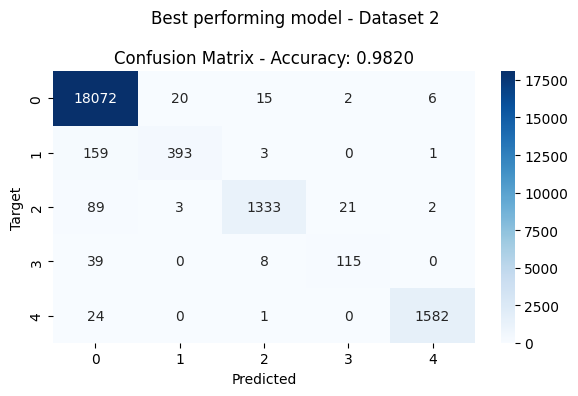

In [35]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
ac = accuracy_score(y, yhat)

# Plotting
plt.figure(figsize=(6, 4))
sns.heatmap(cfm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - Accuracy: {ac:.4f}")
plt.suptitle("Best performing model - Dataset 2")
plt.xlabel("Predicted")
plt.ylabel("Target")
plt.tight_layout()
plt.savefig("confusion_matrix_with_accuracy_big_best_epoch15.png")
plt.show()
